<a href="https://colab.research.google.com/github/kowsiknd/MNIST-PyTorch/blob/main/MNIST_Fully_Connected_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.__version__

'1.9.0+cu102'

In [3]:
%mkdir data

mkdir: cannot create directory ‘data’: File exists


Loading Datasets

In [4]:
dataset = tv.datasets.MNIST(root='data/', download=True, transform=tv.transforms.ToTensor())

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
type(dataset)

torchvision.datasets.mnist.MNIST

torch.Size([1, 28, 28])


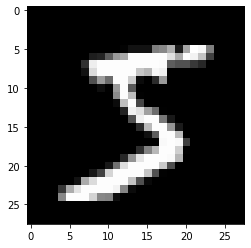

5


In [6]:
image, label = dataset[0]
print (image.shape)
plt.imshow(image.squeeze(0), cmap="gray") # Squeezed to remove the first dimension from 1 * 28 * 28
plt.show()
print (label)


Total samples in dataset

In [7]:
len(dataset)

60000

Hyper parameters

In [8]:
val_size = 1000
train_size = len(dataset) - val_size
batch_size = 32

In [9]:
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

In [10]:
from torch.utils.data import DataLoader

In [11]:
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    # pin_memory, num_workers
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=True,
    # pin_memory, num_workers
)

images.shape: torch.Size([32, 1, 28, 28])
label.shape: torch.Size([32])


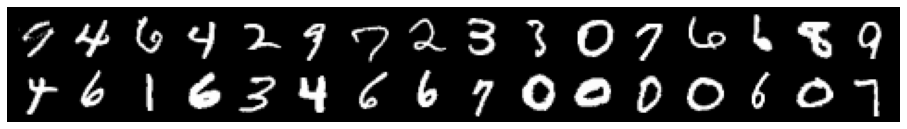

In [12]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print('label.shape:', labels.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(tv.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Model

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class MnistModel(nn.Module):
  def __init__(self, input_shape=(28*28), output_shape=10):
    super().__init__()
    self.layer1 = nn.Linear(input_shape, 512)
    self.layer2 = nn.Linear(512, 128)
    self.layer3 = nn.Linear(128, 64)
    self.out_layer = nn.Linear(64, output_shape)

  def forward(self, xb):
    x = xb.view(xb.size(0), -1)
    x = self.layer1(x)
    x = F.relu(x)

    x = self.layer2(x)
    x = F.relu(x)

    x = self.layer3(x)
    x = F.relu(x)

    out = self.out_layer(x)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
    acc = accuracy(out, labels)
    return {
        "val_loss": loss,
        "val_acc": acc
    }

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {
        "val_loss": loss,
        "val_acc": acc
    }

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {
      "val_loss": epoch_loss.item(),
      "val_acc": epoch_acc.item()
    }

    
  def epoch_end(self, epoch, total_epochs, result):
    print("Epoch [{}/{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, total_epochs, result["val_loss"], result["val_acc"]))


In [15]:
input_shape = 28 * 28
output_shape = 10

In [16]:
model = MnistModel(
    input_shape,
    output_shape
)

In [17]:
from torchsummary import summary

In [18]:
summary(model, input_size=(1, input_shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 128]          65,664
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 10]             650
Total params: 476,490
Trainable params: 476,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.82
Estimated Total Size (MB): 1.83
----------------------------------------------------------------


In [19]:
for t in model.parameters():
    print(t.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [20]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print("Loss: ", loss)
  print('outputs.shape : ', outputs.shape)
  print('Sample outputs :\n', outputs[:2].data)
  break

Loss:  tensor(2.3129, grad_fn=<NllLossBackward>)
outputs.shape :  torch.Size([32, 10])
Sample outputs :
 tensor([[-0.0491,  0.0717, -0.0031, -0.0699, -0.0342, -0.1228, -0.0334,  0.0666,
          0.1227, -0.0447],
        [-0.0358,  0.0812,  0.0039, -0.0661, -0.0240, -0.1181, -0.0262,  0.0633,
          0.1339, -0.0374]])


## To Device

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [22]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [23]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [24]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [25]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 3, 0, 5, 9, 1, 4, 1, 6, 3, 2, 2, 6, 6, 3, 0, 3, 9, 6, 2, 7, 3, 1, 7,
        2, 8, 0, 9, 6, 3, 7, 7])


## Train

In [26]:
def evaluate(model, val_loader):
  outputs = [ model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [27]:
def fit(model, train_loader, val_loader, epochs=10, lr=0.001, optim_func=torch.optim.Adam):
  history = []
  optimizer = optim_func(model.parameters(), lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, epochs, result)
    history.append(result)

  return history


In [28]:
to_device(model, device=device)

MnistModel(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=10, bias=True)
)

In [29]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.083984375, 'val_loss': 2.3029747009277344}]

In [30]:
history += fit(model, train_loader, val_loader, epochs=10, lr=0.001, optim_func=torch.optim.Adam)


Epoch [1/10], val_loss: 0.0991, val_acc: 0.9648
Epoch [2/10], val_loss: 0.0939, val_acc: 0.9727
Epoch [3/10], val_loss: 0.0982, val_acc: 0.9746
Epoch [4/10], val_loss: 0.0991, val_acc: 0.9795
Epoch [5/10], val_loss: 0.1075, val_acc: 0.9736
Epoch [6/10], val_loss: 0.1237, val_acc: 0.9756
Epoch [7/10], val_loss: 0.1131, val_acc: 0.9688
Epoch [8/10], val_loss: 0.1097, val_acc: 0.9824
Epoch [9/10], val_loss: 0.1022, val_acc: 0.9824
Epoch [10/10], val_loss: 0.1117, val_acc: 0.9766


In [32]:
torch.save(model, '/content/drive/MyDrive/MNIST/mnist_pytorch.pth')